# German Road sign Classifier


## German Traffic Sign Recognition Benchmark

Its a collection of images of traffic signs commonly seen in Germany.

It includes 43 different types of traffic signs, like signs that tell you the speed limit, where to go, what to do, and warning and regulatory signs.


## Import Necessary Liberaries

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
import random
from matplotlib.image import imread
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# set random seed for reproducibility
np.random.seed(42)

# import deep learning models
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import metrics for evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

# import machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# import preprocessing modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection


## Data Loading and Pre-Processing

In [2]:
# specify the directory paths
data_dir = 'D:\Mtech\Sem-2\DLVR\Assignment\gts'
train_path = 'D:\Mtech\Sem-2\DLVR\Assignment\gts\Train'
test_path = 'D:\Mtech\Sem-2\DLVR\Assignment\gts\Test'

# define image dimensions and number of channels
IMG_HEIGHT = 75
IMG_WIDTH = 75
channels = 3

In [3]:
# determine the number of classes
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
# Mapping class indices to their corresponding labels
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

### Analyzing Class Distribution

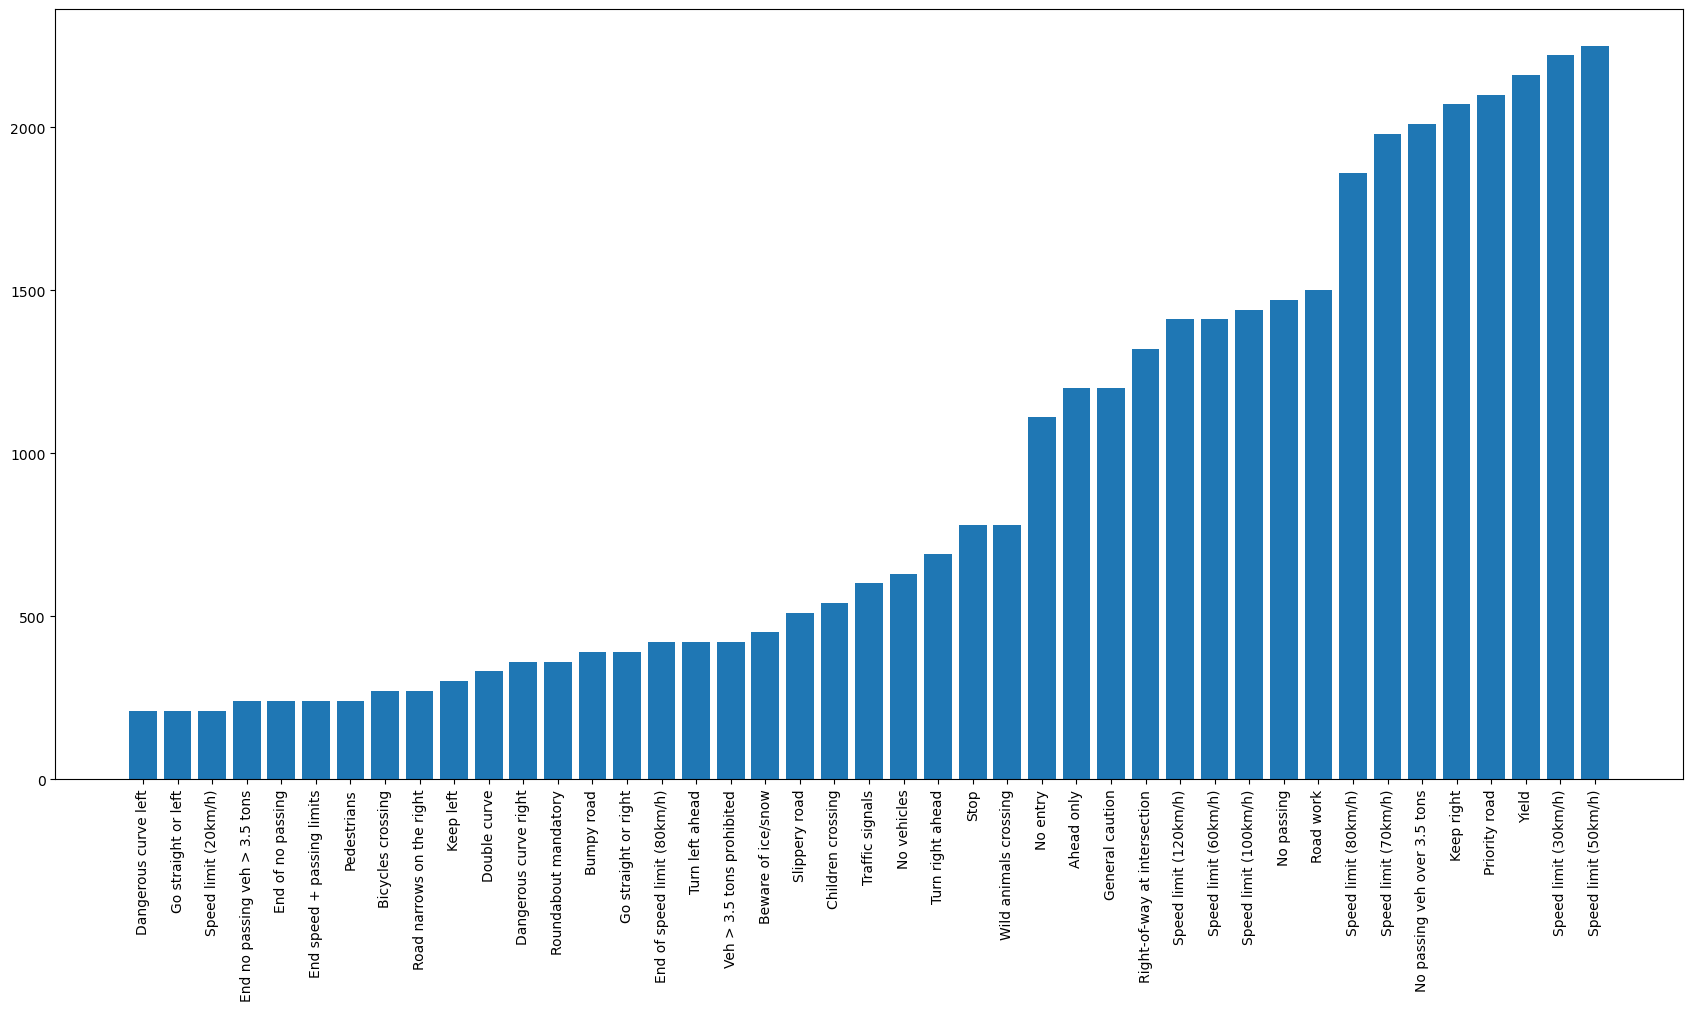

In [5]:
# Extracting the number of images in each class and sorting the dataset based on the number of images
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

### Loading Image Data and Labels

In [6]:
# Initializing empty lists to store image data and labels
image_data = []
image_labels = []
# Looping through each category (class) in the dataset
for i in range(NUM_CATEGORIES):
     # Generating the path to the directory containing images for the current category
    path = data_dir + '/Train/' + str(i)
    # Listing all image files in the current category directory
    images = os.listdir(path)
 # Looping through each image file in the current category
    for img in images:
        try:
            image = cv2.imread(path + '/' + img) # Reading the image using OpenCV
            image_fromarray = Image.fromarray(image, 'RGB')  # Converting the image to RGB format using PIL
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH)) # Resizing the image to the specified dimensions
            image_data.append(np.array(resize_image))  # Converting the resized image to numpy array and appending to image_data list
            image_labels.append(i) # Appending the label (category index) to the image_labels list
        except:
            print("Error in " + img)

# Converting the lists to numpy arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)

# Printing the shape of image data and labels arrays
print(image_data.shape, image_labels.shape)

(39209, 75, 75, 3) (39209,)


### Shuffling Image Data and Labels


In [7]:
shuffle_indexes = np.arange(image_data.shape[0]) # Generating an array of shuffled indices
np.random.shuffle(shuffle_indexes) # Shuffling the indices randomly

# Shuffling the image data and labels arrays based on the shuffled indices
image_data = image_data[shuffle_indexes] 
image_labels = image_labels[shuffle_indexes]

### Splitting Data into Training and Validation Sets

In [8]:
# Splitting the dataset into training and validation sets with a test size of 30%
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)
# Normalizing pixel values to the range [0, 1]
X_train = X_train/255 
X_val = X_val/255
# Printing the shapes of the training and validation sets
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape) 
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 75, 75, 3)
X_valid.shape (11763, 75, 75, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## InceptionV3

In [9]:
# Loading the InceptionV3 model with pretrained ImageNet weights
base_model_inception= InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, channels))

In [10]:
# Freeze the layers in the base model
for layer in base_model_inception.layers:
    layer.trainable = False

In [11]:
x = base_model_inception.output # Getting the output tensor of the InceptionV3 base model
x = GlobalAveragePooling2D()(x) # Adding a global average pooling layer to reduce the spatial dimensions
x = Dense(1024, activation='relu')(x) # Adding a fully connected dense layer with 1024 units and ReLU activation
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x) # Adding the final output layer with softmax activation for multi-class classification

In [12]:
model = Model(inputs=base_model_inception.input, outputs=predictions) # Creating the final model by specifying the input and output layers

In [13]:
# Compiling the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary() # Displaying the summary of the compiled model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 37, 37,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 35, 35,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 35, 35,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 17, 17,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 17, 17,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 23,945,035 (91.34 MB)

 Trainable params: 2,142,251 (8.17 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [15]:
# Creating ImageDataGenerator objects for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255)  # Rescaling pixel values of training images
val_datagen = ImageDataGenerator(rescale=1./255)  # Rescaling pixel values of validation images

In [16]:
# Creating data generators for training and validation sets
train_generator = train_datagen.flow(X_train, y_train, batch_size=32) # Generating batches of augmented training data
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)  # Generating batches of augmented validation data

In [17]:
# Training the model on the training data and validating it on the validation data
history_inception = model.fit(train_generator, epochs=15, validation_data=val_generator)

Epoch 1/15


D:\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 189s 204ms/step - accuracy: 0.1246 - loss: 3.3603 - val_accuracy: 0.2695 - val_loss: 2.5126
Epoch 2/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 175s 204ms/step - accuracy: 0.2941 - loss: 2.4323 - val_accuracy: 0.3724 - val_loss: 2.1518
Epoch 3/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 174s 203ms/step - accuracy: 0.3531 - loss: 2.1700 - val_accuracy: 0.3940 - val_loss: 2.0304
Epoch 4/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 177s 207ms/step - accuracy: 0.4039 - loss: 1.9896 - val_accuracy: 0.4416 - val_loss: 1.8724
Epoch 5/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 177s 206ms/step - accuracy: 0.4353 - loss: 1.8685 - val_accuracy: 0.4533 - val_loss: 1.8488
Epoch 6/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 178s 207ms/step - accuracy: 0.4539 - loss: 1.7940 - val_accuracy: 0.4460 - val_loss: 1.8006
Epoch 7/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 180s 210ms/step - accuracy: 0.4779 - loss: 1.6988 - val_accuracy: 0.4791 - val_loss: 1.7164
Epoch 8/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 177s 206ms/step - accuracy: 0.4926 - loss: 1.65

In [18]:
# Evaluating the model on the validation data generator
val_loss, val_acc = model.evaluate(val_generator)
print("Validation Accuracy:", val_acc)

368/368 ━━━━━━━━━━━━━━━━━━━━ 52s 142ms/step - accuracy: 0.5593 - loss: 1.4119
Validation Accuracy: 0.5584459900856018


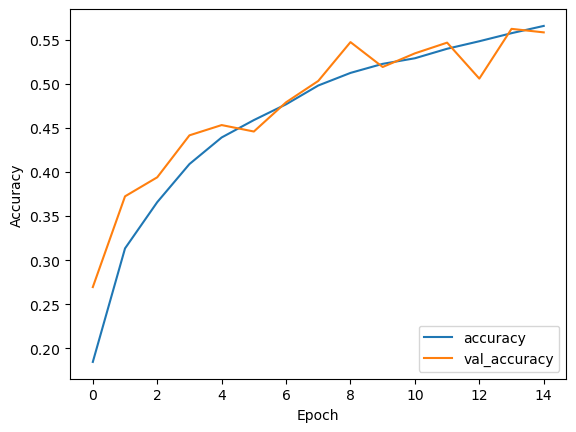

In [19]:
plt.plot(history_inception.history['accuracy'], label='accuracy') # Plotting the training accuracy over epochs
plt.plot(history_inception.history['val_accuracy'], label='val_accuracy') # Plotting the validation accuracy over epochs
plt.xlabel('Epoch') # Labeling the x-axis as 'Epoch'
plt.ylabel('Accuracy') # Labeling the y-axis as 'Accuracy'
plt.legend(loc='lower right') # Adding legend to the plot indicating training and validation accuracy
plt.show() # Displaying the plot

In [20]:
y_pred = model.predict(val_generator) # Predicting class probabilities for the validation data using the trained model
y_pred_classes = np.argmax(y_pred, axis=1) # Extracting the predicted classes by selecting the class with the highest probability

368/368 ━━━━━━━━━━━━━━━━━━━━ 58s 148ms/step


In [21]:
val_generator.reset()  # Reset generator to the beginning
y_true = []
for i in range(len(val_generator)):
    _, labels_batch = val_generator[i]  # Get batch of images and labels
    y_true.extend(labels_batch)  # Extend y_true with batch of true labels

In [22]:
# Printing the classification report for the Inception model
print("Classification Report for Inception:")
print(classification_report(y_true, y_pred_classes))

Classification Report for Inception:
              precision    recall  f1-score   support

           0       0.04      0.02      0.02        63
           1       0.06      0.10      0.08       653
           2       0.07      0.02      0.03       685
           3       0.03      0.04      0.03       421
           4       0.06      0.04      0.05       581
           5       0.03      0.04      0.04       556
           6       0.00      0.00      0.00       121
           7       0.02      0.02      0.02       447
           8       0.04      0.08      0.05       424
           9       0.04      0.03      0.03       470
          10       0.04      0.04      0.04       623
          11       0.02      0.03      0.03       388
          12       0.07      0.06      0.06       651
          13       0.07      0.07      0.07       673
          14       0.01      0.01      0.01       231
          15       0.01      0.02      0.01       187
          16       0.02      0.01      0.01 

In [23]:
# Printing the confusion matrix for the Inception model
print("Confusion Matrix for Inception:")
print(confusion_matrix(y_true, y_pred_classes))

Confusion Matrix for Inception:
[[ 1  1  3 ...  0  0  1]
 [ 0 68 15 ...  1  3  6]
 [ 2 55 16 ...  3  2  2]
 ...
 [ 0 14  2 ...  0  0  0]
 [ 0  8  2 ...  0  0  0]
 [ 1  4  0 ...  0  1  1]]


## Xception

In [24]:
# Loading the Xception model with pre-trained weights from ImageNet, excluding the top classification layer and specifying the input shape 
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, channels))

In [25]:
# Freeze the layers in the base model
for layer in base_model_xception.layers:
    layer.trainable = False

In [26]:
x = base_model_xception.output # Extracting the output tensor from the Xception base model
x = GlobalAveragePooling2D()(x) # Adding a global average pooling layer to reduce the spatial dimensions of the feature maps
x = Dense(1024, activation='relu')(x) # Adding a fully connected layer with 1024 units and ReLU activation function
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x) # Adding the final output layer with softmax activation for multiclass classification

In [27]:
model = Model(inputs=base_model_xception.input, outputs=predictions) # Creating the final model by specifying the input and output layers

In [28]:
 # Compiling the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary() # Displaying the summary of the Xception model

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 37, 37,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 37, 37,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 37, 37,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 35, 35,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 35, 35,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 35, 35,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 35, 35,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 35, 35,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 35, 35,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 35, 35,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 35, 35,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 18, 18,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 18, 18,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 18, 18,    │        512 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 18, 18,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 18, 18,    │          0 │ add[0][0]       

 Total params: 23,003,731 (87.75 MB)

 Trainable params: 2,142,251 (8.17 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [30]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255) # Creating an ImageDataGenerator for data augmentation during training, rescaling the pixel values to [0,1]
val_datagen = ImageDataGenerator(rescale=1./255) # Creating an ImageDataGenerator for rescaling pixel values to [0,1] for validation data

In [31]:
# Create generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32) # Creating generator for training data using train_datagen
val_generator = val_datagen.flow(X_val, y_val, batch_size=32) # Creating generator for validation data using val_datagen

In [32]:
# Fitting the model on training data using the generator, with 15 epochs and validation data specified
history_xception = model.fit(train_generator, epochs=15, validation_data=val_generator)

Epoch 1/15


D:\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 463s 531ms/step - accuracy: 0.0538 - loss: 3.5432 - val_accuracy: 0.0555 - val_loss: 3.4806
Epoch 2/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 445s 519ms/step - accuracy: 0.0530 - loss: 3.4927 - val_accuracy: 0.0582 - val_loss: 3.4805
Epoch 3/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 444s 518ms/step - accuracy: 0.0588 - loss: 3.4924 - val_accuracy: 0.0582 - val_loss: 3.4780
Epoch 4/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 448s 523ms/step - accuracy: 0.0589 - loss: 3.4807 - val_accuracy: 0.0570 - val_loss: 3.4689
Epoch 5/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 435s 508ms/step - accuracy: 0.0660 - loss: 3.4735 - val_accuracy: 0.0571 - val_loss: 3.4540
Epoch 6/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 433s 504ms/step - accuracy: 0.0706 - loss: 3.4622 - val_accuracy: 0.0774 - val_loss: 3.4339
Epoch 7/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 433s 505ms/step - accuracy: 0.0757 - loss: 3.4340 - val_accuracy: 0.0829 - val_loss: 3.4158
Epoch 8/15
858/858 ━━━━━━━━━━━━━━━━━━━━ 434s 506ms/step - accuracy: 0.0787 - loss: 3.41

In [33]:
# Evaluating the model on the validation generator
val_loss, val_acc = model.evaluate(val_generator)
print("Validation Accuracy:", val_acc)

368/368 ━━━━━━━━━━━━━━━━━━━━ 132s 359ms/step - accuracy: 0.0748 - loss: 3.3602
Validation Accuracy: 0.07744622975587845


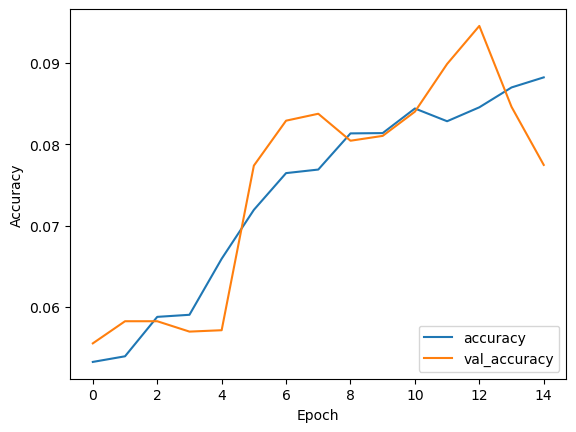

In [34]:
# Plotting the training and validation accuracy over epochs
plt.plot(history_xception.history['accuracy'], label='accuracy')  # Plotting training accuracy
plt.plot(history_xception.history['val_accuracy'], label='val_accuracy')  # Plotting validation accuracy
plt.xlabel('Epoch')  # Labeling x-axis
plt.ylabel('Accuracy')  # Labeling y-axis
plt.legend(loc='lower right')  # Adding legend to the plot
plt.show()  # Displaying the plot


In [35]:
# Generating predictions using the trained model on the validation set
y_pred = model.predict(val_generator)  # Predicting class probabilities for the validation data
y_pred_classes = np.argmax(y_pred, axis=1)  # Extracting the predicted classes from the predicted probabilities


368/368 ━━━━━━━━━━━━━━━━━━━━ 135s 363ms/step


In [36]:
# Resetting the validation generator to the beginning
val_generator.reset()

# Initializing an empty list to store true labels
y_true = []

# Looping through each batch in the validation generator
for i in range(len(val_generator)):
    # Getting the batch of images and labels
    _, labels_batch = val_generator[i]
    # Extending y_true with the batch of true labels
    y_true.extend(labels_batch)


In [37]:
# Printing the classification report for Xception

print("Classification Report for Xception:")
print(classification_report(y_true, y_pred_classes))

Classification Report for Xception:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.05      0.47      0.10       653
           2       0.00      0.00      0.00       685
           3       0.00      0.00      0.00       421
           4       0.00      0.00      0.00       581
           5       0.00      0.00      0.00       556
           6       0.00      0.00      0.00       121
           7       0.00      0.00      0.00       447
           8       0.00      0.00      0.00       424
           9       0.00      0.00      0.00       470
          10       0.06      0.07      0.07       623
          11       0.05      0.03      0.04       388
          12       0.06      0.01      0.01       651
          13       0.06      0.40      0.10       673
          14       0.00      0.00      0.00       231
          15       0.00      0.00      0.00       187
          16       0.00      0.00      0.00  

D:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
# Printing the confusion matrix for Xception
print("Confusion Matrix for Xception:")
print(confusion_matrix(y_true, y_pred_classes))

Confusion Matrix for Xception:
[[  0  24   0 ...   0   0   0]
 [  0 306   0 ...   0   0   0]
 [  0 322   0 ...   0   0   0]
 ...
 [  0  53   0 ...   0   0   0]
 [  0  39   0 ...   0   0   0]
 [  0  26   0 ...   0   0   0]]


Accuracy:

- **Inception**: The accuracy of Inception on the validation set after 15 epochs is approximately 55.93%.
- **Xception**: The accuracy of Xception on the validation set after 15 epochs is approximately 7.48%.

Loss:

- **Inception**: The loss of Inception on the validation set after 15 epochs is approximately 1.4119.
- **Xception**: The loss of Xception on the validation set after 15 epochs is approximately 3.3602.

Precision, Recall, and F1-score:

- Both models show very low precision, recall, and F1-score across all classes.
- Inception tends to have slightly higher precision, recall, and F1-scores compared to Xception, but the differences are not significant.

Confusion Matrix:

- The confusion matrices for both models show a lot of misclassifications across different classes, indicating that both models struggle with distinguishing between different classes.


## Inference

- **Inception** performs better than **Xception** in accuracy and loss.Both the architectures got challenges in classifying images into correct  categories.By checking **precision,recall and F1-scores** the values are less and also **confusion matrix** the misclassifications are high.By changing dataset quality by feature engineering,different model architecture ,hyperparameter tuning and other type of training methods.By doing techniques like fine-tuning,trianing for more time or refining the architecture improves performance.


- To conclude **InceptionV3** approach have performed well,in case of Xception we can cleary see accuracy increases very slow it may perform good if we increase number of epochs and steps per epochshs.


## Extract Deep Features

### Creating a feature extractor using InceptionV3


In [39]:
# Defining the feature extractor model using InceptionV3
feature_extractor_inception = Model(inputs=base_model_inception.input, outputs=base_model_inception.get_layer('mixed7').output)

### Extracting features for training data using InceptionV3


In [40]:
# Extracting features for training data using InceptionV3 feature extractor
train_features_inception = feature_extractor_inception.predict(X_train)
print("Shape of training features extracted using InceptionV3:", train_features_inception.shape)

858/858 ━━━━━━━━━━━━━━━━━━━━ 94s 106ms/step
Shape of training features extracted using InceptionV3: (27446, 3, 3, 768)


### Extracting features for validation data using InceptionV3

In [41]:
# Extracting features for validation data using InceptionV3 feature extractor
val_features_inception = feature_extractor_inception.predict(X_val)
print("Shape of validation features extracted using InceptionV3:", val_features_inception.shape)

368/368 ━━━━━━━━━━━━━━━━━━━━ 46s 100ms/step
Shape of validation features extracted using InceptionV3: (11763, 3, 3, 768)


### Creating Xception Feature Extractor


In [42]:
# Creating Xception feature extractor to extract features from a specific layer
feature_extractor_xception = Model(inputs=base_model_xception.input, outputs=base_model_xception.get_layer('block12_sepconv2_act').output)

### Extracting Features for training data Using Xception


In [43]:
# Extracting features for training data using Xception feature extractor
train_features_xception = feature_extractor_xception.predict(X_train)
print("Shape of training features extracted using Xception:", train_features_xception.shape)

858/858 ━━━━━━━━━━━━━━━━━━━━ 259s 289ms/step
Shape of training features extracted using Xception: (27446, 5, 5, 728)


### Extracting Features Using Xception for Validation Data


In [44]:
# Extracting features for validation data using Xception feature extractor
val_features_xception = feature_extractor_xception.predict(X_val)
print("Shape of validation features extracted using Xception:", val_features_xception.shape)

368/368 ━━━━━━━━━━━━━━━━━━━━ 104s 281ms/step
Shape of validation features extracted using Xception: (11763, 5, 5, 728)


In [45]:
# Resizing the extracted features from InceptionV3 for training and validation data
resized_train_features_inception = np.resize(train_features_inception, (train_features_inception.shape[0], 5, 5, 728))
resized_val_features_inception = np.resize(val_features_inception, (val_features_inception.shape[0], 5, 5, 728))

In [46]:
# Flatten the features before concatenation
flattened_train_features_inception = train_features_inception.reshape(train_features_inception.shape[0], -1)
flattened_val_features_inception = val_features_inception.reshape(val_features_inception.shape[0], -1)
flattened_train_features_xception = train_features_xception.reshape(train_features_xception.shape[0], -1)
flattened_val_features_xception = val_features_xception.reshape(val_features_xception.shape[0], -1)

In [47]:
# Reduce dimensionality separately for each set of features using Random Projection
rp_inception = GaussianRandomProjection(n_components=50)  # You can adjust the number of components as needed
rp_xception = GaussianRandomProjection(n_components=50)  # You can adjust the number of components as needed

In [48]:
# Transforming the flattened features using Random Projection for both InceptionV3 and Xception
reduced_train_features_inception = rp_inception.fit_transform(flattened_train_features_inception)
reduced_val_features_inception = rp_inception.transform(flattened_val_features_inception)

reduced_train_features_xception = rp_xception.fit_transform(flattened_train_features_xception)
reduced_val_features_xception = rp_xception.transform(flattened_val_features_xception)

In [49]:
# Concatenating the reduced features from both InceptionV3 and Xception for training data
combined_train_features = np.concatenate((reduced_train_features_inception, reduced_train_features_xception), axis=-1)
# Concatenating the reduced features from both InceptionV3 and Xception for validation data
combined_val_features = np.concatenate((reduced_val_features_inception, reduced_val_features_xception), axis=-1)

In [50]:
# Printing the shape of combined training features
print("Shape of combined training features:", combined_train_features.shape)

# Printing the shape of combined validation features
print("Shape of combined validation features:", combined_val_features.shape)

Shape of combined training features: (27446, 100)
Shape of combined validation features: (11763, 100)


In [51]:
# Reshaping the combined training features
X_train_flattened = combined_train_features.reshape(combined_train_features.shape[0], -1)
# Reshaping the combined validation features
X_val_flattened = combined_val_features.reshape(combined_val_features.shape[0], -1)

In [52]:
X_train_flattened.shape

(27446, 100)

In [53]:
X_val_flattened.shape

(11763, 100)

In [54]:
# Splitting the combined training features and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(combined_train_features, y_train, test_size=0.2, random_state=42)

In [55]:
X_train.shape

(21956, 100)

In [56]:
 X_val.shape

(5490, 100)

In [57]:
y_train.shape

(21956,)

In [58]:
y_val.shape

(5490,)

## Logistic Regression

In [59]:
# Initialize Logistic Regression model
logistic_model = LogisticRegression()

# Train the Logistic Regression model
logistic_model.fit(X_train, y_train)

# Predictions
train_preds = logistic_model.predict(X_train)
val_preds = logistic_model.predict(X_val)

# Evaluation
train_accuracy = accuracy_score(y_train, train_preds)
val_accuracy = accuracy_score(y_val, val_preds)

D:\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
# Printing the title for Logistic Regression model evaluation
print("Logistic Regression Model:")

# Printing the training accuracy of Logistic Regression model
print(f"Training Accuracy: {train_accuracy}")

# Printing the validation accuracy of Logistic Regression model
print(f"Validation Accuracy: {val_accuracy}")


Logistic Regression Model:
Training Accuracy: 0.7763253780287849
Validation Accuracy: 0.7320582877959927


In [61]:
print("Classification Report:")
print(classification_report(y_val, val_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        25
           1       0.66      0.63      0.64       318
           2       0.59      0.60      0.60       317
           3       0.49      0.46      0.47       191
           4       0.67      0.63      0.65       305
           5       0.60      0.62      0.61       254
           6       0.75      0.86      0.80        44
           7       0.69      0.72      0.70       169
           8       0.69      0.59      0.64       203
           9       0.80      0.83      0.81       219
          10       0.74      0.84      0.79       274
          11       0.62      0.66      0.64       169
          12       0.97      0.95      0.96       294
          13       0.95      0.96      0.96       288
          14       0.91      0.98      0.94       105
          15       0.90      0.96      0.93        72
          16       0.78      0.85      0.81        67
    

In [62]:
print("Confusion Matrix:")
print(confusion_matrix(y_val, val_preds))

Confusion Matrix:
[[ 14   6   2 ...   0   0   0]
 [  1 199  49 ...   2   1   0]
 [  0  25 191 ...   0   0   0]
 ...
 [  0   1   0 ...  38   0   0]
 [  0   0   0 ...   0  24   0]
 [  0   0   2 ...   0   6  27]]


## Support Vector Machine(SVM)

In [63]:
# Initialize SVM classifier model
svm_classifier = SVC()

# Train the SVM classifier model
svm_classifier.fit(X_train, y_train)

# Predictions
train_preds_svm = svm_classifier.predict(X_train)
val_preds_svm = svm_classifier.predict(X_val)

# Evaluation
train_accuracy_svm = accuracy_score(y_train, train_preds_svm)
val_accuracy_svm = accuracy_score(y_val, val_preds_svm)

In [64]:
# Printing the title for SVM Classifier model evaluation
print("Support Vector Machine (SVM) Classifier Model:")

# Printing the training accuracy of SVM model
print(f"Training Accuracy: {train_accuracy_svm}")

# Printing the validation accuracy of SVM model
print(f"Validation Accuracy: {val_accuracy_svm}")


Support Vector Machine (SVM) Classifier Model:
Training Accuracy: 0.9007105119329568
Validation Accuracy: 0.8493624772313297


In [65]:
print("Classification Report:")
print(classification_report(y_val, val_preds_svm))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57        25
           1       0.77      0.79      0.78       318
           2       0.70      0.78      0.73       317
           3       0.68      0.66      0.67       191
           4       0.81      0.77      0.79       305
           5       0.75      0.78      0.76       254
           6       0.93      0.93      0.93        44
           7       0.84      0.82      0.83       169
           8       0.83      0.68      0.75       203
           9       0.93      0.95      0.94       219
          10       0.89      0.95      0.92       274
          11       0.70      0.83      0.76       169
          12       0.96      0.98      0.97       294
          13       0.98      0.98      0.98       288
          14       0.98      0.99      0.99       105
          15       1.00      1.00      1.00        72
          16       1.00      0.94      0.97        67
    

In [66]:
print("Confusion Matrix:")
print(confusion_matrix(y_val, val_preds_svm))

Confusion Matrix:
[[ 10  14   1 ...   0   0   0]
 [  0 251  32 ...   0   0   0]
 [  0  15 246 ...   0   0   0]
 ...
 [  0   0   0 ...  47   0   0]
 [  0   0   0 ...   0  32   0]
 [  0   0   1 ...   0   2  40]]


###  K-Nearest Neighbors (KNN) Classifier

In [67]:
# Initialize KNN classifier model
knn_classifier = KNeighborsClassifier()

# Train the KNN classifier model
knn_classifier.fit(X_train, y_train)

# Predictions
train_preds_knn = knn_classifier.predict(X_train)
val_preds_knn = knn_classifier.predict(X_val)

# Evaluation
train_accuracy_knn = accuracy_score(y_train, train_preds_knn)
val_accuracy_knn = accuracy_score(y_val, val_preds_knn)


In [68]:
# Printing the title for KNN Classifier model evaluation
print("KNN Classifier Model:")

# Printing the training accuracy of KNN Classifier model
print(f"Training Accuracy: {train_accuracy_knn}")

# Printing the validation accuracy of KNN Classifier model
print(f"Validation Accuracy: {val_accuracy_knn}")


KNN Classifier Model:
Training Accuracy: 0.9650209509928949
Validation Accuracy: 0.9218579234972678


In [69]:
print("Classification Report:")
print(classification_report(y_val, val_preds_knn))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.91      0.94      0.92       318
           2       0.85      0.89      0.87       317
           3       0.80      0.79      0.80       191
           4       0.87      0.86      0.86       305
           5       0.87      0.89      0.88       254
           6       0.96      0.98      0.97        44
           7       0.89      0.91      0.90       169
           8       0.85      0.86      0.86       203
           9       0.97      0.93      0.95       219
          10       0.95      0.95      0.95       274
          11       0.87      0.95      0.91       169
          12       0.99      0.98      0.99       294
          13       0.99      0.99      0.99       288
          14       0.99      0.99      0.99       105
          15       1.00      0.99      0.99        72
          16       1.00      0.99      0.99        67
    

In [70]:
print("Confusion Matrix:")
print(confusion_matrix(y_val, val_preds_knn))

Confusion Matrix:
[[ 23   2   0 ...   0   0   0]
 [  0 298   6 ...   0   0   0]
 [  0  15 283 ...   0   0   0]
 ...
 [  0   0   0 ...  52   0   0]
 [  0   0   0 ...   0  33   0]
 [  0   0   0 ...   0   3  42]]


## Multinomial Naive Bayes

In [71]:
# Replace negative values with zeros
X_train_non_negative = X_train.copy()
X_train_non_negative[X_train_non_negative < 0] = 0

# Scale features to ensure non-negative values
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_non_negative)

# Initialize and fit the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_scaled, y_train)

# Predictions
train_preds_nb = nb_classifier.predict(X_train_scaled)
val_preds_nb = nb_classifier.predict(X_val)

# Calculate accuracies
train_accuracy_nb = accuracy_score(y_train, train_preds_nb)
val_accuracy_nb = accuracy_score(y_val, val_preds_nb)

In [72]:
# Printing the title for Multinomial Naive Bayes Classifier model evaluation
print("\nMultinomial Naive Bayes Classifier Model:")

# Printing the training accuracy of Multinomial Naive Bayes Classifier model
print(f"Training Accuracy: {train_accuracy_nb}")

# Printing the validation accuracy of Multinomial Naive Bayes Classifier model
print(f"Validation Accuracy: {val_accuracy_nb}")



Multinomial Naive Bayes Classifier Model:
Training Accuracy: 0.4568682820185826
Validation Accuracy: 0.3016393442622951


In [73]:
print("Classification Report:")
print(classification_report(y_val, val_preds_nb))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.35      0.48      0.40       318
           2       0.20      0.23      0.21       317
           3       0.33      0.01      0.01       191
           4       0.19      0.33      0.24       305
           5       0.16      0.73      0.26       254
           6       0.18      0.70      0.29        44
           7       0.34      0.15      0.21       169
           8       0.24      0.03      0.06       203
           9       0.75      0.10      0.17       219
          10       0.43      0.42      0.42       274
          11       0.21      0.44      0.28       169
          12       0.88      0.38      0.53       294
          13       0.98      0.64      0.77       288
          14       0.97      0.60      0.74       105
          15       0.54      0.57      0.55        72
          16       1.00      0.03      0.06        67
    

D:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [74]:
print("Confusion Matrix:")
print(confusion_matrix(y_val, val_preds_nb))

Confusion Matrix:
[[  0  19   2 ...   0   0   0]
 [  0 152  33 ...   0   0   0]
 [  0  38  72 ...   0   0   0]
 ...
 [  0   4   8 ...   6   0   0]
 [  0   0   2 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


### Compare the performance measures

Logistic Regression Model:

- Training Accuracy: 77.63%
- Validation Accuracy: 72.0%
- The precision, recall, and F1-score vary across different classes, but overall, the model demonstrates moderate performance.
- The confusion matrix shows that the model struggles with correctly classifying certain classes, indicating areas for improvement.

Support Vector Machine (SVM) Classifier Model:

- Training Accuracy: 90.0%
- Validation Accuracy: 84.9%
- The precision, recall, and F1-score are relatively high across most classes, indicating good performance.
- However, there are still some classes where the model's performance is suboptimal, as shown in the confusion matrix.

KNN Classifier Model:

- Training Accuracy: 96.5%
- Validation Accuracy: 92.1%
- The model demonstrates high accuracy, precision, recall, and F1-score across most classes, indicating excellent performance.
- The confusion matrix shows minimal misclassifications, highlighting the effectiveness of the KNN classifier.

Multinomial Naive Bayes Classifier Model:

- Training Accuracy: 45.6%
- Validation Accuracy: 30.1%
- The precision, recall, and F1-score are low across most classes, indicating poor performance.
- The confusion matrix reveals significant misclassifications, suggesting that the model struggles to accurately classify images.


### Inference

- By seeing this performance evaluation,**K-Nearest Neighbor Classifier(KNN)** and **Support vector Machine(SVM)** gave higher validation accuracy of **91.86%** and **85.57%** this can be achived by taking **deep features** form those two architecture **Inception** and **Xception**. The other two algorithms Logistic regression and Multinomial Naive Bayes can perform good but it may require optimization.Since it a multiclass classification Algorithms available is very minimal even selecting ML model plays a vital role.Fine-tuning all ML models can result in enhancing validation accuracy. 


- To conclude **K-Nearest Neighbor Classifier(KNN)** performs good for deep features,Fine-tuning other algorithms may also result in performing betterer